In [ ]:
!pip install profanity-check==1.0.3

In [ ]:
!pip install pyarrow

In [2]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import pyarrow as pa   
import pyarrow.parquet as pq
#from fastparquet import ParquetFile
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob, Word
from sklearn.externals import joblib
import json
import cx_Oracle

In [ ]:
from profanity_check import predict, predict_prob

predict(['predict() takes an array and returns a 1 for each string if it is offensive, else 0.'])
# [0]

predict(['fuck you'])
# [1]

predict_prob(['predict_prob() takes an array and returns the probability each string is offensive'])
# [0.08686173]

predict_prob(['go to hell, you scum'])
# [0.7618861]

In [ ]:
translations = translator.translate(['The quick brown fox', 'jumps over', 'the lazy dog'], dest='ko')
for translation in translations:
    print(translation.origin, ' -> ', translation.text)

In [ ]:
! pip install googletrans

In [3]:
con =  cx_Oracle.connect('comprasweb_ij/Xxxx1234!@10.10.2.223/MKTG')
print(con.version)

df = pd.read_sql_query('''
SELECT * 
FROM --DISTINCT para empresas
(
SELECT 
	RATINGEVENTOBJECTTARGETID,
	s.DT,
	TRUNC(s.RATINGEVENTOBJECTINSTANT) AS fecha_review,
	s.RATINGEVENTOBJECTSCORE,
	REPLACE(REPLACE(s.REVIEWNAME, '?', 'n'),'n', 'n') AS REVIEWNAME,
    REPLACE(REPLACE(s.REVIEWVALUE, '?', 'n'),'n', 'n') AS REVIEWVALUE
FROM DWHPRO.COMPANY_REVIEW s 
WHERE --to_date(DT) BETWEEN to_date('01/09/2018') AND to_date('31/12/2019')
s.REVIEWVALUE like '%mierda%'
)t 
pivot (
min(REVIEWVALUE) value FOR REVIEWNAME IN ('title', 'description')
)
''', con)
df_save = df

con.close()

11.2.0.3.0


In [4]:
df.head()

,RATINGEVENTOBJECTTARGETID,DT,FECHA_REVIEW,RATINGEVENTOBJECTSCORE,'title'_VALUE,'description'_VALUE
0,32419379426,2019-04-04,2019-04-04,3,None,te esclavizan y no cobras una mierda
1,34192244053,2019-01-30,2019-01-30,1,Contratos de mierda,"Pesima empresa, contratos de mierda..."
2,32283914570,2019-01-30,2019-01-30,1,mierda,mierda
3,34197338953,2019-07-18,2019-07-18,1,None,"es una mierda de empresa, pagan una miseria, p..."
4,34191392168,2019-03-16,2019-03-16,1,Es una autentica mierda.,None


In [5]:
df.shape

(556, 6)

In [6]:
df = df[['RATINGEVENTOBJECTTARGETID','DT','RATINGEVENTOBJECTSCORE',"'title'_VALUE","'description'_VALUE"]]

In [7]:
df = df.rename(columns={"RATINGEVENTOBJECTTARGETID": "EXPERIENCE_ID"
                            ,"DT": "FECHA"
                            ,"RATINGEVENTOBJECTSCORE": "RATING"
                            ,"'title'_VALUE": "TITLE"
                            ,"'description'_VALUE": "DESCRIPTION"
                           })

In [8]:
#df['T+D'] = df[['TITLE', 'DESCRIPTION']].apply(lambda x: ''.join(x), axis=1)
df['TD'] = df.TITLE.astype(str).str.cat(df.DESCRIPTION.astype(str), sep=' ')

In [9]:
df["is_bad_review"] = df["RATING"].apply(lambda x: 1 if x < 3 else 0)
# select only relevant columns
df.head()

,EXPERIENCE_ID,FECHA,RATING,TITLE,DESCRIPTION,TD,is_bad_review
0,32419379426,2019-04-04,3,None,te esclavizan y no cobras una mierda,None te esclavizan y no cobras una mierda,0
1,34192244053,2019-01-30,1,Contratos de mierda,"Pesima empresa, contratos de mierda...","Contratos de mierda Pesima empresa, contratos ...",1
2,32283914570,2019-01-30,1,mierda,mierda,mierda mierda,1
3,34197338953,2019-07-18,1,None,"es una mierda de empresa, pagan una miseria, p...","None es una mierda de empresa, pagan una miser...",1
4,34191392168,2019-03-16,1,Es una autentica mierda.,None,Es una autentica mierda. None,1


In [10]:
#quitar ultimos caracteres extraños manualmente
df["TD"] = df["TD"].apply(lambda x: 
x.replace("!", "").replace("?", "n").replace("Enter", "").replace("enter", "").replace("None", "")
)

In [11]:
#df_bad = df[df['T+D'].notnull()]
df_bad = df[df['TD'].notnull()]

In [12]:
df_bad.head(5)

,EXPERIENCE_ID,FECHA,RATING,TITLE,DESCRIPTION,TD,is_bad_review
0,32419379426,2019-04-04,3,None,te esclavizan y no cobras una mierda,te esclavizan y no cobras una mierda,0
1,34192244053,2019-01-30,1,Contratos de mierda,"Pesima empresa, contratos de mierda...","Contratos de mierda Pesima empresa, contratos ...",1
2,32283914570,2019-01-30,1,mierda,mierda,mierda mierda,1
3,34197338953,2019-07-18,1,None,"es una mierda de empresa, pagan una miseria, p...","es una mierda de empresa, pagan una miseria, ...",1
4,34191392168,2019-03-16,1,Es una autentica mierda.,None,Es una autentica mierda.,1


In [13]:
import string
punctuation=string.punctuation

In [14]:
from nltk.corpus import stopwords

In [15]:
stop = stopwords.words('spanish')

In [16]:
df_example = df_bad

In [17]:
df_example.head()

,EXPERIENCE_ID,FECHA,RATING,TITLE,DESCRIPTION,TD,is_bad_review
0,32419379426,2019-04-04,3,None,te esclavizan y no cobras una mierda,te esclavizan y no cobras una mierda,0
1,34192244053,2019-01-30,1,Contratos de mierda,"Pesima empresa, contratos de mierda...","Contratos de mierda Pesima empresa, contratos ...",1
2,32283914570,2019-01-30,1,mierda,mierda,mierda mierda,1
3,34197338953,2019-07-18,1,None,"es una mierda de empresa, pagan una miseria, p...","es una mierda de empresa, pagan una miseria, ...",1
4,34191392168,2019-03-16,1,Es una autentica mierda.,None,Es una autentica mierda.,1


In [18]:
import spacy
nlp = spacy.load('es_core_news_sm')

In [19]:
def cleanup_text(docs, logging=False):
    texts = []
    doc = nlp(docs, disable=['parser', 'ner'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stop and tok not in punctuation]
    tokens = ' '.join(tokens)
    texts.append(tokens)
    return pd.Series(texts)

In [21]:
df_example['clean_text'] = df_example['TD'].apply(lambda x: cleanup_text(x, False))

In [72]:
df_example.head()

,EXPERIENCE_ID,FECHA,RATING,TITLE,DESCRIPTION,TD,is_bad_review,clean_text
0,32419379426,2019-04-04,3,None,te esclavizan y no cobras una mierda,te esclavizan y no cobras una mierda,0,esclavizar cobrar mierda
1,34192244053,2019-01-30,1,Contratos de mierda,"Pesima empresa, contratos de mierda...","Contratos de mierda Pesima empresa, contratos ...",1,contratos mierda pesima empresa contrato mierd...
2,32283914570,2019-01-30,1,mierda,mierda,mierda mierda,1,mierda mierda
3,34197338953,2019-07-18,1,None,"es una mierda de empresa, pagan una miseria, p...","es una mierda de empresa, pagan una miseria, ...",1,ser mierda empresa pagar miseria parir nivel e...
4,34191392168,2019-03-16,1,Es una autentica mierda.,None,Es una autentica mierda.,1,autenticar mierda


In [ ]:
! pip install -U textblob

In [ ]:
! python -m textblob.download_corpora

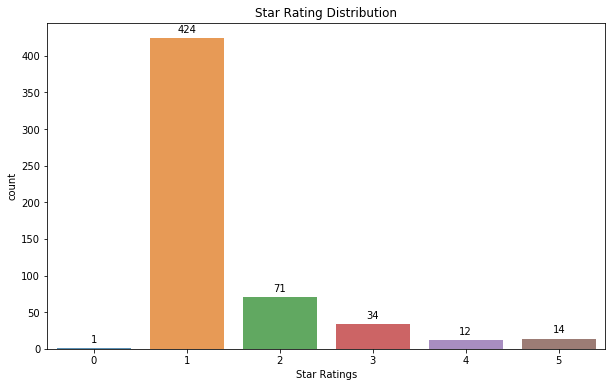

In [22]:
x = df_example['RATING'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 0.8) 
plt.title ("Star Rating Distribution") 
plt.ylabel ('count') 
plt.xlabel ('Star Ratings') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();

In [56]:
#Load the data 
df_csv = pd.read_csv('diccionario.csv')#, encoding='latin-1', sep='|', header=None)

In [57]:
df_csv=df_csv['Abadol'].str.lower()

In [59]:
df_csv = df_csv.tolist()

In [73]:
lista_insultos = df_csv

In [132]:
lista_insultos = lista_insultos + ['puto']

In [133]:
frame = pd.DataFrame({'a' : ['the cat is mierda', 'the sky is puto', 'the dog is alelada', 'the dog is alacrán']})

frame

,a
0,the cat is mierda
1,the sky is puto
2,the dog is alelada
3,the dog is alacrán


In [134]:
mylist = lista_insultos
pattern = '|'.join(mylist)

frame['es_insulto'] = frame.a.str.contains(pattern)

In [135]:
frame

,a,es_insulto
0,the cat is mierda,True
1,the sky is puto,True
2,the dog is alelada,True
3,the dog is alacrán,True


In [136]:
pattern

"abejarruca|abejarruco|aberracion|aberración|aberrante|ablanda brevas|abollao|aborto|abrazafarolas|abrillantaglandes|abulto|adán|afilasables|aguafiestas|alacrán|alcachofo|alcornoke|alcornoque|alela|alelada|alelado|alelao|alfeñique|alicate|alimaña|almojonao|almorrana|alobao|alsarrabo|ambercocat|amochao|amorfo|anacoluto|analfabestia|animal de acequia|anormal|antancanciao|apollardao|apollardar|aragán|arracacho|arrastramantas|arrastrazapatillas|arreplegat|arrollapasto|artosopas|asalta asilos|asaltacunas|asaltapozos|ase assolellat|aspamao|asustatrenes|atonta|atontada|atontado|atontao|atroplella platos|baballo|babau|baboso|bacin|bacterio|badanas|bailabainas|bailaferias|bajoca|bambol|bandarra|barjaula|barriobajero|bastarda|bastardo|bebecharcos|bebesinsed|bellaco|bergante|berzotas|besugo|betzol|bigardo|bigotezorra|biruta|bleda|boba|bobo|bobolaverga|bobomierda|boborremoto|bocabuzón|bocachancla|bocachocho|bocafiemo|boiano|bolascombro|boludo|bordegàs|borinot|borracha|borracho|borrico|bosses trist

In [140]:
df_example['es_insulto'] = df_example.clean_text.str.contains(pattern)

In [151]:
df_example[df_example['es_insulto']==1]

,EXPERIENCE_ID,FECHA,RATING,TITLE,DESCRIPTION,TD,is_bad_review,clean_text,es_insulto
0,32419379426,2019-04-04,3,None,te esclavizan y no cobras una mierda,te esclavizan y no cobras una mierda,0,esclavizar cobrar mierda,True
1,34192244053,2019-01-30,1,Contratos de mierda,"Pesima empresa, contratos de mierda...","Contratos de mierda Pesima empresa, contratos ...",1,contratos mierda pesima empresa contrato mierd...,True
2,32283914570,2019-01-30,1,mierda,mierda,mierda mierda,1,mierda mierda,True
3,34197338953,2019-07-18,1,None,"es una mierda de empresa, pagan una miseria, p...","es una mierda de empresa, pagan una miseria, ...",1,ser mierda empresa pagar miseria parir nivel e...,True
4,34191392168,2019-03-16,1,Es una autentica mierda.,None,Es una autentica mierda.,1,autenticar mierda,True
5,34196238612,2019-06-06,1,None,La mayor mierda q hay,La mayor mierda q hay,1,mayor mierda q haber,True
6,34194148501,2019-06-05,1,una mierda doble,una mierda,una mierda doble una mierda,1,mierda doblar mierda,True
7,34195689509,2019-05-20,2,None,Siempre buscan nuevas formas de penalizaciones...,Siempre buscan nuevas formas de penalizacione...,1,siempre buscar nuevo formar penalización parir...,True
8,34193190205,2019-02-28,1,None,Una mierda porque el bar esta chapado.,Una mierda porque el bar esta chapado.,1,mierda bar chapar,True
9,34195366619,2019-05-10,5,None,"Como empresa bien, la ETT fue una mierda.","Como empresa bien, la ETT fue una mierda.",0,empresa bien ett ser mierda,True


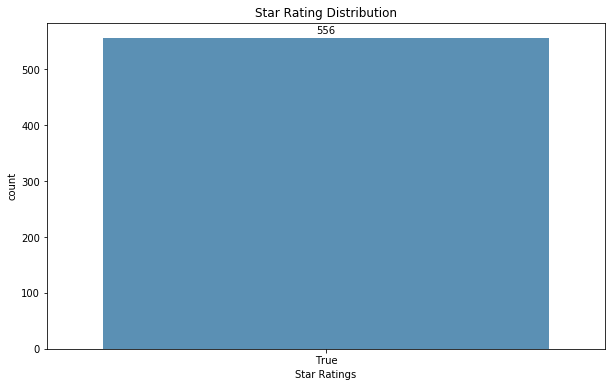

In [152]:
x = df_example['es_insulto'].value_counts () 
x = x.sort_index () 
plt.figure(figsize = (10,6)) 
ax = sns.barplot (x.index, x.values, alpha = 0.8) 
plt.title ("Star Rating Distribution") 
plt.ylabel ('count') 
plt.xlabel ('Star Ratings') 
rects = ax.patches 
labels = x.values 
for rect, label in zip (rects, labels): 
    height = rect.get_height () 
    ax.text (rect.get_x () + rect.get_width () / 2, height + 5, label, ha = 'center', va = 'bottom') 
plt.show ();